The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


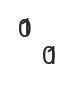

In [359]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 150
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm.auto import tqdm
from datetime import datetime as dt

# Load models together
from src.torch_utils import load_model_full
from src.multimodal_metrics import BSSVAELoss
from src.utils import get_class_initcode_keys
from src.multimodal_models import BSSVAE
from src.multimodal_train_eval import predict_multimodal, multimodal_train_eval_loops, train_multimodal_step, eval_multimodal_step
from src.multimodal_datasets import MultimodalPepTCRDataset, MultimodalCLFLatentDataset
from src.datasets import TwoStageTCRpMHCDataset, FullTCRDataset, LatentTCRpMHCDataset, TCRSpecificDataset
from torch.utils.data import SequentialSampler
from src.datasets import *
from src.models import *
%load_ext autoreload
%autoreload 2
    
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.utils import pkl_load, pkl_dump, get_palette
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE
from src.metrics import reconstruction_accuracy, VAELoss, TripletLoss, CombinedVAELoss, compute_cosine_distance
from src.datasets import TCRSpecificDataset, FullTCRDataset
import torch
from torch import optim
from torch.utils.data import RandomSampler, SequentialSampler
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180



def get_model(folder, **kwargs):
    pt = glob.glob(folder+'/*checkpoint_best*.pt')
    pt = [x for x in pt if 'interval' not in x][0]
    js = glob.glob(folder+'/*checkpoint*.json')[0]
    model = load_model_full(pt, js, **kwargs)
    return model
    

In [12]:
m = get_model('../output/240404_FirstBestLast_comparison/mmvaes/240325_1327_BSSVAE_addlencTrue_addldecTrue_bnTrue_LONG25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_IzcVOH/',
             map_location='cpu')

Reloading best model:
epoch: 669
total: 0.24167719816201078
recon_marg: 0.058951238294695785
recon_joint: 0.06029103156074707
kld_marg: 2.8083470404482448e-05
kld_joint: 0.12240684622103679
tcr_marg_seq_accuracy: 0.48559725284576416
tcr_joint_seq_accuracy: 0.47769173979759216
pep_joint_seq_accuracy: 0.7373113036155701
pep_marg_seq_accuracy: 0.7518730163574219
wmean_seq_accuracy: 0.5605287954211235


# Use either only FullTCR or only CDR3

Use models without peptide as input ; For BSS / JM VAEs, can use the TCR-side part of the encoders

In [545]:
coslimited_df.groupby(['peptide','origin']).count()

A1   A2   A3   B1   B2   B3  allele  partition  binder  \
peptide    origin                                                            
AVFDRKSDAK 10x     143  143  143  143  143  143     143        143     143   
ELAGIGILTV 10x      80   80   80   80   80   80      80         80      80   
           IEDB      5    5    5    5    5    5       5          5       5   
           VDJdb     7    7    7    7    7    7       7          7       7   
GILGFVFTL  10x     135  135  135  135  135  135     135        135     135   
           IEDB     23   23   23   23   23   23      23         23      23   
           VDJdb    75   75   75   75   75   75      75         75      75   
KLGGALQAK  10x     181  181  181  181  181  181     181        181     181   
LLWNGPMAV  IEDB     34   34   34   34   34   34      34         34      34   
           VDJdb    41   41   41   41   41   41      41         41      41   
NLVPMVATV  IEDB      8    8    8    8    8    8       8          8       8   
           VDJdb    66   66   66   66   66   66      66         66      66   
RAKFKQLL   10x     166  166  166  166  166  166     166        166     166   
SPRWYFYYL  IEDB     17   17   17   17   17   17      17         17      17   
           VDJdb    72   72   72   72   72   72      72         72      72   
TTDPSFLGRY IEDB      2    2    2    2    2    2       2          2       2   
           VDJdb    76   76   76   76   76   76      76         76      76   
YLQPRTFLL  IEDB      2    2    2    2    2    2       2          2       2   
           VDJdb    78   78   78   78   78   78      78         78      78   

                   original_peptide  ...  z_92  z_93  z_94  z_95  z_96  z_97  \
peptide    origin                    ...                                       
AVFDRKSDAK 10x                  143  ...   143   143   143   143   143   143   
ELAGIGILTV 10x                   80  ...    80    80    80    80    80    80   
           IEDB                   5  ...     5     5     5     5     5     5   
           VDJdb                  7  ...     7     7     7     7     7     7   
GILGFVFTL  10x                  135  ...   135   135   135   135   135   135   
           IEDB                  23  ...    23    23    23    23    23    23   
           VDJdb                 75  ...    75    75    75    75    75    75   
KLGGALQAK  10x                  181  ...   181   181   181   181   181   181   
LLWNGPMAV  IEDB                  34  ...    34    34    34    34    34    34   
           VDJdb                 41  ...    41    41    41    41    41    41   
NLVPMVATV  IEDB                   8  ...     8     8     8     8     8     8   
           VDJdb                 66  ...    66    66    66    66    66    66   
RAKFKQLL   10x                  166  ...   166   166   166   166   166   166   
SPRWYFYYL  IEDB                  17  ...    17    17    17    17    17    17   
           VDJdb                 72  ...    72    72    72    72    72    72   
TTDPSFLGRY IEDB                   2  ...     2     2     2     2     2     2   
           VDJdb                 76  ...    76    76    76    76    76    76   
YLQPRTFLL  IEDB                   2  ...     2     2     2     2     2     2   
           VDJdb                 78  ...    78    78    78    78    78    78   

                   z_98  z_99  fold  fulltcr  
peptide    origin                             
AVFDRKSDAK 10x      143   143   143      143  
ELAGIGILTV 10x       80    80    80       80  
           IEDB       5     5     5        5  
           VDJdb      7     7     7        7  
GILGFVFTL  10x      135   135   135      135  
           IEDB      23    23    23       23  
           VDJdb     75    75    75       75  
KLGGALQAK  10x      181   181   181      181  
LLWNGPMAV  IEDB      34    34    34       34  
           VDJdb     41    41    41       41  
NLVPMVATV  IEDB       8     8     8        8  
           VDJdb     66    66    66       66  
RAKFKQLL   10x      166   166   166      1

In [91]:
# For BSSVAE, Df is duplicated 3 times : because we go through the "3" modalities (TCR, Pep, paired)
# To get the TCR part, do .loc[:1960]
bssdf = pd.read_csv('../output/240324_MMVAES/240321_ADDLAYERS/240322_1416_RESUME_ADDKLDN_BSSVAE_allTrue_10kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_yOqyC6/valid_predictions_kcv_f00_240322_1416_RESUME_ADDKLDN_BSSVAE_allTrue_10kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_yOqyC6.csv')
stcrdf = pd.read_csv('../output/240404_TCRONLY_onetwostage_smallLARGE/240404_1150_ExpData_TCRONLY_1stage_LARGE_256h_100l_NoTrp_KFold_0_LARGETCRP1/valid_predictions_kcv_240311_nettcr_pairedAB_expanded_noswap_f00_240404_1150_ExpData_TCRONLY_1stage_LARGE_256h_100l_NoTrp_KFold_0_LARGETCRP1.csv')
cosdf = pd.read_csv('../output/240404_TCRONLY_onetwostage_smallLARGE/240404_2342_ExpData_TCRONLY_1stage_LARGE_256h_100l_CosTrp_KFold_0_SmCosTCRP1/valid_predictions_kcv_240311_nettcr_pairedAB_expanded_noswap_f00_240404_2342_ExpData_TCRONLY_1stage_LARGE_256h_100l_CosTrp_KFold_0_SmCosTCRP1.csv')
len(bssdf.drop_duplicates(subset=['peptide','A1','A2','A3','B1','B2','B3'])), len(stcrdf)
display(bssdf.head(3))
display(stcrdf.head(3))

,peptide,A1,A2,A3,B1,B2,B3,allele,binder,target,...,z_91,z_92,z_93,z_94,z_95,z_96,z_97,z_98,z_99,fold
0,RAKFKQLL,TISGTDY,GLTSN,IQSQGGSEKLV,SGHDT,YYEEEE,ASSLRDGSEAF,HLA-B*08:01,1.0,NaN,...,-0.030315,0.630402,-0.061242,0.288611,0.848534,0.266395,0.532458,0.211411,0.190118,0
1,YLYALVYFL,TSDPSYG,QGSYDQQN,AMREGKNDYKLS,SGHDT,YYEEEE,ASSFGGVEGMNTEAF,HLA-A*02:01,1.0,NaN,...,-0.116279,0.824002,1.853908,-0.059586,0.720120,0.306077,0.669701,-0.009777,-0.135003,0
2,KLSALGINAV,TSESDYY,QEAYKQQN,AWRGGGGADGLT,MNHEY,SVGEGT,ASSWDPTYNEQF,HLA-A*02:01,1.0,NaN,...,-0.208192,0.833056,0.374255,-0.204106,0.577718,-3.375388,0.702590,-0.351612,-0.199378,0


,peptide,A1,A2,A3,B1,B2,B3,allele,partition,binder,...,z_91,z_92,z_93,z_94,z_95,z_96,z_97,z_98,z_99,fold
0,RAKFKQLL,TISGTDY,GLTSN,IQSQGGSEKLV,SGHDT,YYEEEE,ASSLRDGSEAF,HLA-B*08:01,0,1,...,2.429806,-0.625789,-1.936006,0.996946,0.239063,-1.269450,0.899635,-0.854365,0.144581,0
1,YLYALVYFL,TSDPSYG,QGSYDQQN,AMREGKNDYKLS,SGHDT,YYEEEE,ASSFGGVEGMNTEAF,HLA-A*02:01,0,1,...,-0.668173,-0.468289,3.393375,0.225074,-0.821956,1.037017,0.690047,-0.341352,-1.499044,0
2,KLSALGINAV,TSESDYY,QEAYKQQN,AWRGGGGADGLT,MNHEY,SVGEGT,ASSWDPTYNEQF,HLA-A*02:01,0,1,...,0.763271,0.696995,2.894275,0.724968,2.887076,1.084999,-0.864339,1.104071,0.026000,0


In [49]:
from sklearn.cluster import AgglomerativeClustering, HDBSCAN, OPTICS, DBSCAN, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from src.sim_utils import make_dist_matrix

def get_linkage_matrix(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    return linkage_matrix


def get_aggcluster_heatmap_plot(preds, linkage='average', distance_threshold=0.457675, title='', fn='file'):
    sample = preds.query('partition==1')[['A1', 'A2', 'A3', 'B1', 'B2', 'B3']+[z for z in preds.columns if z.startswith('z_')]+['peptide', 'original_peptide']].sort_values('original_peptide')
    sample_dist_matrix = make_dist_matrix(sample)
    # Do agglomerative clustering with hyperparameters found earlier
    agg = AgglomerativeClustering(n_clusters=None, metric='precomputed', linkage=linkage, distance_threshold=distance_threshold)
    predicted_clusters = agg.fit_predict(sample_dist_matrix.drop(columns=['peptide','original_peptide']).values)
    linkage_matrix = get_linkage_matrix(agg)
    
    # Get a PCA of the features
    features = sample[[z for z in preds.columns if z.startswith('z_')]+['peptide', 'original_peptide']]
    pca = PCA(n_components=15)
    pca_feats = pd.DataFrame(pca.fit_transform(features.drop(columns=['peptide', 'original_peptide']).values), columns = [f'PCA_{i}' for i in range(pca.n_components_)])
    # Create the colour scheme
    features = features.rename(columns={'original_peptide':'label'})
    labels = features.pop('label')
    row_colors = {k:v for k,v in zip(labels.unique(), sns.color_palette('Paired', 26))}
    mapped_colors = labels.map(row_colors).reset_index(drop=True)
    
    g = sns.clustermap(pca_feats, col_cluster=False, row_linkage=linkage_matrix, col_linkage=None, row_colors=mapped_colors, cbar_pos=(.975, .35, .035, .45),
                   label=True, cmap = 'viridis', z_score=0, dendrogram_ratio=(0.2, 0))
    fig = g.fig
    ax = g.ax_heatmap
    ax.set_yticklabels([])
    ax.set_yticks([])
    fig.suptitle(title, y=1.05)
    g.savefig(f'{fn}.png', dpi=180)

In [92]:
# Take the TCR only part for BSSVAE df
bssdm = make_dist_matrix(bssdf.loc[:1960].reset_index(drop=True), cols=['peptide','binder'])
bss_array = bssdm.iloc[:, :-2].values
tcrdm = make_dist_matrix(stcrdf.reset_index(drop=True), cols=['peptide','binder'])
tcr_array = tcrdm.iloc[:, :-2].values
cosdm = make_dist_matrix(cosdf.loc[:1960].reset_index(drop=True), cols=['peptide','binder'])
cos_array = cosdm.iloc[:, :-2].values
labels = tcrdm['peptide'].values

In [109]:
top5 = cosdm.groupby('peptide').agg(count=('binder','count')).sort_values('count',ascending=False).head(5).index
tmp = cosdm.query('peptide in @top5')
toy = tmp.loc[tmp.index, tmp.index.to_list()+['peptide']]
toy_array = toy.drop(columns=['peptide']).values
toy_triu = toy_array[np.triu(np.ones(toy_array.shape),k=1)==1]
toy_labels = toy['peptide'].values

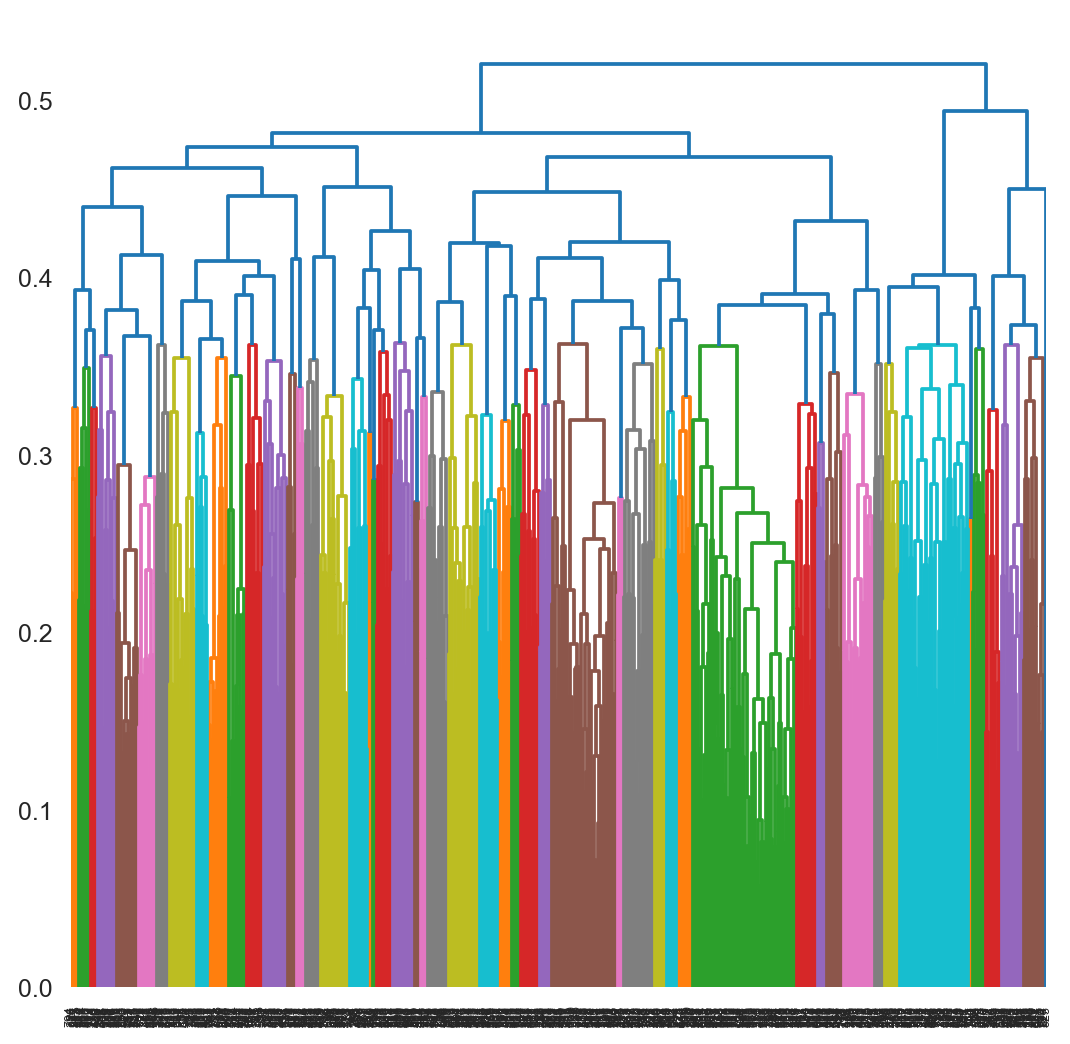

[Text(5, 0, '794'),
 Text(15, 0, '384'),
 Text(25, 0, '26'),
 Text(35, 0, '234'),
 Text(45, 0, '247'),
 Text(55, 0, '323'),
 Text(65, 0, '281'),
 Text(75, 0, '554'),
 Text(85, 0, '2'),
 Text(95, 0, '740'),
 Text(105, 0, '358'),
 Text(115, 0, '561'),
 Text(125, 0, '595'),
 Text(135, 0, '750'),
 Text(145, 0, '465'),
 Text(155, 0, '382'),
 Text(165, 0, '779'),
 Text(175, 0, '714'),
 Text(185, 0, '271'),
 Text(195, 0, '273'),
 Text(205, 0, '206'),
 Text(215, 0, '130'),
 Text(225, 0, '19'),
 Text(235, 0, '435'),
 Text(245, 0, '196'),
 Text(255, 0, '262'),
 Text(265, 0, '12'),
 Text(275, 0, '605'),
 Text(285, 0, '454'),
 Text(295, 0, '335'),
 Text(305, 0, '391'),
 Text(315, 0, '175'),
 Text(325, 0, '237'),
 Text(335, 0, '702'),
 Text(345, 0, '116'),
 Text(355, 0, '608'),
 Text(365, 0, '327'),
 Text(375, 0, '246'),
 Text(385, 0, '256'),
 Text(395, 0, '688'),
 Text(405, 0, '301'),
 Text(415, 0, '708'),
 Text(425, 0, '501'),
 Text(435, 0, '263'),
 Text(445, 0, '580'),
 Text(455, 0, '570'),
 Tex

In [116]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
# Assuming X is your distance matrix or data
Z = linkage(toy_triu, method='complete', metric='cosine', optimal_ordering=True)  # or 'single', 'complete', 'average'
f,a = plt.subplots(1,1, figsize=(7,7))
dendrogram(Z, ax=a)
plt.show()
a.get_xticklabels()
# label_colors = {k:c for k,c in zip(set(toy_labels), get_palette('Set1', len(set(toy_labels))))}
# sns.clustermap(toy.drop(columns=['peptide']), method='complete', col_cluster=False, row_colors=label_colors, figsize=(10,7))

# Tuning HP and checking metrics

In [131]:
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.metrics import calinski_harabasz_score as ch_score, davies_bouldin_score as db_score
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score

In [134]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(cosdf['peptide'].values)

In [331]:
def get_purity(counts):
    # Purity in absolute % of a cluster, taking the majority label 
    # high = better
    sorted_counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
    return sorted_counts[list(sorted_counts.keys())[0]] / sum(sorted_counts.values())
    
def get_mixity(counts):
    # how many different labels are inside a cluster, weighted by the number of members
    # low = better
    return len(counts.keys()) / sum(counts.values())
    
def get_coherence(dist_array):
    # Assumes dist_array is the subset of the distance array for a given cluster label
    # mean distance within a cluster
    # low = better

    # get upper triangle mask without the diagonale
    mask = np.triu(np.ones(dist_array.shape), k=0) - np.eye(dist_array.shape[0])
    flat_array = dist_array[mask==1]
    return np.mean(flat_array)

def get_purity_mixity_coherence(cluster_label:int, 
                                true_labels:list, 
                                pred_labels:list, 
                                dist_array:np.array,
                                label_encoder):
    """
        For a given cluster label (int) returned by clustering.labels_, 
        Return the purity, mixity, coherence, cluster_size, and scale (==cluster_size/total_size)
        scale should be used to get a weighted average metric at the end
    """
    indices = np.where(pred_labels==cluster_label)[0]
    cluster_size = len(indices)
    if cluster_size<=1:
        # return np.nan, np.nan, np.nan, 1, 1/len(true_labels)
        return {'purity':np.nan, 'coherence':np.nan, 'cluster_size':1}

    # Query the subset of the true labels belonging to this cluster using indices 
    # Convert to int label encodings in order to use np.bincount to get purity and mixity
    subset = true_labels[indices]
    encoded_subset = label_encoder.transform(subset)
    counts = {i:k for i,k in enumerate(np.bincount(encoded_subset)) if k>0}
    
    purity = get_purity(counts)
    # mixity = get_mixity(counts)
    # index the distance matrix and return the mean distance within this cluster (i.e. coherence)
    coherence = get_coherence(dist_array[indices][:, indices])
    
    # return purity, mixity, coherence, cluster_size, cluster_size / len(true_labels)
    return {'purity':purity, 'coherence':coherence, 'cluster_size':cluster_size}

## full valid set

In [301]:
cos_features = cosdf[[x for x in cosdf.columns if x.startswith('z_')]]
cos_results = []

for t in tqdm(np.linspace(0.075, 1, 1500)):
    t = round(t, 5)
    c = AgglomerativeClustering(n_clusters=None, metric='precomputed', distance_threshold=t, linkage='complete')
    c.fit(cos_array)
    
    n_cluster = len(np.unique(c.labels_))
    n_singletons = (np.bincount(c.labels_)==1).sum()
    try:
        s_score = silhouette_score(cos_features, c.labels_, metric='cosine')
    except:
        s_score = np.nan
    try:
        c_score = ch_score(cos_features, c.labels_)
    except:
        c_score = np.nan
    try:
        d_score = db_score(cos_features, c.labels_)
    except:
        d_score = np.nan
    try:
        ari_score = adjusted_rand_score(encoded_labels, c.labels_)
    except:
        ari_score = np.nan

    xd = pd.concat([pd.DataFrame(get_purity_mixity_coherence(k, true_labels, c.labels_, cos_array, label_encoder), index=[0]) for k in set(c.labels_)]).dropna()
    mean_purity = xd['purity'].mean()
    mean_coherence = xd['coherence'].mean()
    mean_cs = xd['cluster_size'].mean()
    cos_results.append({'threshold':t, 'n_cluster':n_cluster, 'n_singletons':n_singletons,
                        'mean_purity':xd['purity'].mean(), 
                        'min_purity':xd['purity'].min(), 
                        'max_purity':xd['purity'].max(), 
                        'mean_coherence':xd['coherence'].mean(), 
                        'min_coherence':xd['coherence'].min(), 
                        'max_coherence':xd['coherence'].max(), 
                        'mean_cluster_size': xd['cluster_size'].mean(),
                        'min_cluster_size': xd['cluster_size'].min(),
                        'max_cluster_size': xd['cluster_size'].max(),
                        'silhouette':s_score,
                        'ch_index':c_score, 'db_index':d_score, 'ARI':ari_score})


100%|██████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [03:34<00:00,  7.01it/s]


In [302]:
tcr_features = stcrdf[[x for x in stcrdf.columns if x.startswith('z_')]]
tcr_results = []

for t in tqdm(np.linspace(0.075, 1, 1500)):
    t = round(t, 5)
    c = AgglomerativeClustering(n_clusters=None, metric='precomputed', distance_threshold=t, linkage='complete')
    c.fit(tcr_array)
    
    n_cluster = len(np.unique(c.labels_))
    n_singletons = (np.bincount(c.labels_)==1).sum()
    try:
        s_score = silhouette_score(tcr_features, c.labels_, metric='cosine')
    except:
        s_score = np.nan
    try:
        c_score = ch_score(tcr_features, c.labels_)
    except:
        c_score = np.nan
    try:
        d_score = db_score(tcr_features, c.labels_)
    except:
        d_score = np.nan
    try:
        ari_score = adjusted_rand_score(encoded_labels, c.labels_)
    except:
        ari_score = np.nan
    xd = pd.concat([pd.DataFrame(get_purity_mixity_coherence(k, true_labels, c.labels_, tcr_array, label_encoder), index=[0]) for k in set(c.labels_)]).dropna()
    mean_purity = xd['purity'].mean()
    mean_coherence = xd['coherence'].mean()
    mean_cs = xd['cluster_size'].mean()
    tcr_results.append({'threshold':t, 'n_cluster':n_cluster, 'n_singletons':n_singletons,
                        'mean_purity':xd['purity'].mean(), 
                        'min_purity':xd['purity'].min(), 
                        'max_purity':xd['purity'].max(), 
                        'mean_coherence':xd['coherence'].mean(), 
                        'min_coherence':xd['coherence'].min(), 
                        'max_coherence':xd['coherence'].max(), 
                        'mean_cluster_size': xd['cluster_size'].mean(),
                        'min_cluster_size': xd['cluster_size'].min(),
                        'max_cluster_size': xd['cluster_size'].max(),
                        'silhouette':s_score,
                        'ch_index':c_score, 'db_index':d_score, 'ARI':ari_score})


100%|██████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [06:55<00:00,  3.61it/s]


In [ ]:
bss_features = bssdf[[x for x in bssdf.columns if x.startswith('z_')]]
bss_results = []

for t in tqdm(np.linspace(0.075, 1, 1500)):
    t = round(t, 5)
    c = AgglomerativeClustering(n_clusters=None, metric='precomputed', distance_threshold=t, linkage='complete')
    c.fit(bss_array)
    
    n_cluster = len(np.unique(c.labels_))
    n_singletons = (np.bincount(c.labels_)==1).sum()
    
    try:
        s_score = silhouette_score(bss_features, c.labels_, metric='cosine')
    except:
        s_score = np.nan
    try:
        c_score = ch_score(bss_features, c.labels_)
    except:
        c_score = np.nan
    try:
        d_score = db_score(bss_features, c.labels_)
    except:
        d_score = np.nan
    try:
        ari_score = adjusted_rand_score(encoded_labels, c.labels_)
    except:
        ari_score = np.nan
    xd = pd.concat([pd.DataFrame(get_purity_mixity_coherence(k, true_labels, c.labels_, bss_array, label_encoder), index=[0]) for k in set(c.labels_)]).dropna()
    mean_purity = xd['purity'].mean()
    mean_coherence = xd['coherence'].mean()
    mean_cs = xd['cluster_size'].mean()
    bss_results.append({'threshold':t, 'n_cluster':n_cluster, 'n_singletons':n_singletons,
                        'mean_purity':xd['purity'].mean(), 
                        'min_purity':xd['purity'].min(), 
                        'max_purity':xd['purity'].max(), 
                        'mean_coherence':xd['coherence'].mean(), 
                        'min_coherence':xd['coherence'].min(), 
                        'max_coherence':xd['coherence'].max(), 
                        'mean_cluster_size': xd['cluster_size'].mean(),
                        'min_cluster_size': xd['cluster_size'].min(),
                        'max_cluster_size': xd['cluster_size'].max(),
                        'silhouette':s_score,
                        'ch_index':c_score, 'db_index':d_score, 'ARI':ari_score})


In [304]:
cat_results = pd.concat([pd.DataFrame(cos_results).assign(input_type='cos'), 
           pd.DataFrame(tcr_results).assign(input_type='tcr'), 
           pd.DataFrame(bss_results).assign(input_type='bss')])

In [309]:
cat_results.query('mean_purity>0.6').sort_values('n_singletons')

,threshold,n_cluster,n_singletons,mean_purity,min_purity,max_purity,mean_coherence,min_coherence,max_coherence,mean_cluster_size,min_cluster_size,max_cluster_size,silhouette,ch_index,db_index,ARI,input_type
208,0.20335,949,308,0.601086,0.142857,1.0,0.162793,0.045644,0.203293,2.578783,2,18,0.131503,3.219705,1.096716,0.017356,cos
207,0.20274,957,321,0.603191,0.142857,1.0,0.162199,0.045644,0.202461,2.578616,2,18,0.131106,3.210499,1.087353,0.017370,cos
206,0.20212,964,330,0.605356,0.142857,1.0,0.161739,0.045644,0.202109,2.572555,2,18,0.130707,3.203405,1.080706,0.017144,cos
205,0.20150,969,336,0.605542,0.142857,1.0,0.161437,0.045644,0.201453,2.567141,2,18,0.130489,3.200056,1.076136,0.017061,cos
204,0.20088,977,346,0.607223,0.142857,1.0,0.160779,0.030074,0.200604,2.559429,2,18,0.130647,3.192743,1.067354,0.017045,cos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,0.07932,1954,1947,1.000000,1.000000,1.0,0.058188,0.041819,0.076831,2.000000,2,2,0.004517,16.863203,0.157201,0.000142,tcr
6,0.07870,1954,1947,1.000000,1.000000,1.0,0.058188,0.041819,0.076831,2.000000,2,2,0.004517,16.863203,0.157201,0.000142,tcr
0,0.07500,1956,1951,1.000000,1.000000,1.0,0.050812,0.041819,0.058537,2.000000,2,2,0.003684,17.787094,0.143449,0.000101,tcr
1,0.07562,1956,1951,1.000000,1.000000,1.0,0.050812,0.041819,0.058537,2.000000,2,2,0.003684,17.787094,0.143449,0.000101,tcr


In [305]:
cat_results.query('n_singletons<150 and n_cluster>50 and silhouette>0.1').dropna().sort_values('ARI', ascending=False)

,threshold,n_cluster,n_singletons,mean_purity,min_purity,max_purity,mean_coherence,min_coherence,max_coherence,mean_cluster_size,min_cluster_size,max_cluster_size,silhouette,ch_index,db_index,ARI,input_type
337,0.28296,382,4,0.427241,0.100000,1.0,0.204914,0.081295,0.252722,5.177249,2,52,0.102682,4.347183,1.943290,0.046594,cos
339,0.28419,379,4,0.425008,0.100000,1.0,0.205230,0.081295,0.252722,5.218667,2,52,0.101842,4.359808,1.951335,0.046585,cos
338,0.28357,380,4,0.425207,0.100000,1.0,0.205129,0.081295,0.252722,5.204787,2,52,0.101908,4.354669,1.948060,0.046557,cos
340,0.28481,373,4,0.422288,0.100000,1.0,0.205866,0.081295,0.252722,5.303523,2,52,0.100994,4.389465,1.966254,0.046512,cos
341,0.28542,370,4,0.421882,0.100000,1.0,0.206326,0.081295,0.252722,5.346995,2,52,0.100014,4.401682,1.971941,0.046483,cos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
696,0.50449,810,146,0.553143,0.166667,1.0,0.392699,0.087720,0.503715,2.733434,2,13,0.146789,4.076880,1.258759,0.011098,tcr
695,0.50387,810,146,0.553143,0.166667,1.0,0.392699,0.087720,0.503715,2.733434,2,13,0.146789,4.076880,1.258759,0.011098,tcr
697,0.50510,809,146,0.552469,0.166667,1.0,0.392952,0.087720,0.503715,2.737557,2,13,0.146367,4.079675,1.259989,0.011094,tcr
702,0.50819,798,139,0.550312,0.166667,1.0,0.394313,0.087720,0.503715,2.764795,2,13,0.145946,4.092425,1.272146,0.011092,tcr


In [360]:
cat_results.dropna().sort_values('silhouette',ascending=False)

,threshold,n_cluster,n_singletons,mean_purity,min_purity,max_purity,mean_coherence,min_coherence,max_coherence,mean_cluster_size,min_cluster_size,max_cluster_size,silhouette,ch_index,db_index,ARI,input_type
761,0.54460,670,54,0.527450,0.142857,1.000000,0.410371,0.087720,0.543187,3.095779,2,15,0.149487,4.347142,1.439276,0.013406,tcr
760,0.54398,670,54,0.527450,0.142857,1.000000,0.410371,0.087720,0.543187,3.095779,2,15,0.149487,4.347142,1.439276,0.013406,tcr
762,0.54521,670,54,0.527450,0.142857,1.000000,0.410371,0.087720,0.543187,3.095779,2,15,0.149487,4.347142,1.439276,0.013406,tcr
766,0.54768,663,51,0.525554,0.142857,1.000000,0.411093,0.087720,0.543187,3.120915,2,15,0.149368,4.374459,1.450366,0.013375,tcr
765,0.54706,663,51,0.525554,0.142857,1.000000,0.411093,0.087720,0.543187,3.120915,2,15,0.149368,4.374459,1.450366,0.013375,tcr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588,0.43784,24,0,0.215301,0.084337,0.772358,0.285870,0.212371,0.306901,81.708333,23,175,0.003953,12.227458,5.040629,0.065757,cos
589,0.43846,24,0,0.215301,0.084337,0.772358,0.285870,0.212371,0.306901,81.708333,23,175,0.003953,12.227458,5.040629,0.065757,cos
2,0.07623,1956,1951,1.000000,1.000000,1.000000,0.050812,0.041819,0.058537,2.000000,2,2,0.003684,17.787094,0.143449,0.000101,tcr
1,0.07562,1956,1951,1.000000,1.000000,1.000000,0.050812,0.041819,0.058537,2.000000,2,2,0.003684,17.787094,0.143449,0.000101,tcr


In [362]:
cat_results.dropna().sort_values('mean_purity', ascending=False).query('n_singletons<1000')

,threshold,n_cluster,n_singletons,mean_purity,min_purity,max_purity,mean_coherence,min_coherence,max_coherence,mean_cluster_size,min_cluster_size,max_cluster_size,silhouette,ch_index,db_index,ARI,input_type
147,0.16571,1388,993,0.702208,0.166667,1.000000,0.134184,0.030074,0.165653,2.450633,2,14,0.098272,2.937669,0.734433,0.011202,cos
148,0.16633,1382,982,0.702181,0.166667,1.000000,0.134608,0.030074,0.166243,2.447500,2,14,0.099019,2.944856,0.737557,0.011318,cos
149,0.16694,1378,974,0.700179,0.166667,1.000000,0.134924,0.030074,0.166785,2.443069,2,14,0.099413,2.949315,0.739792,0.011313,cos
150,0.16756,1374,968,0.700014,0.166667,1.000000,0.135278,0.030074,0.167317,2.445813,2,14,0.099779,2.954923,0.742059,0.011390,cos
151,0.16818,1366,956,0.695623,0.166667,1.000000,0.135963,0.030074,0.168172,2.451220,2,14,0.100157,2.950372,0.746401,0.011458,cos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737,0.52979,2,0,0.135768,0.087487,0.184049,0.315673,0.314267,0.317079,980.500000,978,983,0.017741,18.346177,10.131841,0.010910,cos
738,0.53040,2,0,0.135768,0.087487,0.184049,0.315673,0.314267,0.317079,980.500000,978,983,0.017741,18.346177,10.131841,0.010910,cos
739,0.53102,2,0,0.135768,0.087487,0.184049,0.315673,0.314267,0.317079,980.500000,978,983,0.017741,18.346177,10.131841,0.010910,cos
741,0.53225,2,0,0.135768,0.087487,0.184049,0.315673,0.314267,0.317079,980.500000,978,983,0.017741,18.346177,10.131841,0.010910,cos


In [ ]:
# Do with a limited amount of peptides

## limited df

In [314]:
top10 = cosdf.groupby('peptide').agg(count=('B3','count')).sort_values('count', ascending=False).head(10).index
coslimited_df = cosdf.query('peptide in @top10')
tcrlimited_df = stcrdf.query('peptide in @top10')
bsslimited_df = bssdf.query('peptide in @top10')

In [530]:
# Make one as well for a reset model
reset_vae = get_model('../output/240404_TCRONLY_onetwostage_smallLARGE/240404_2342_ExpData_TCRONLY_1stage_LARGE_256h_100l_CosTrp_KFold_0_SmCosTCRP1/', map_location='cpu')
print(reset_vae.encoder_mu.weight[0,:5])
reset_vae.reset_parameters(seed=3)
print(reset_vae.encoder_mu.weight[0,:5])

reset_df = coslimited_df.copy()
reset_dataset = FullTCRDataset(reset_df, 7,8,22,6,7,23,0, True, 'BL50LO', -20)
reset_loader = reset_dataset.get_dataloader(1024, SequentialSampler)
reset_df = predict_model(reset_vae, reset_dataset, reset_loader)

Reloading best model:
Best epoch: 11882
total: 0.10637179474033316
reconstruction: 0.08248233795166016
kld: 0.0027784218546003103
triplet: 0.021111038426532353
seq_accuracy: 0.9905097484588623
pos_accuracy: 0.9976889491081238
tensor([ 0.0440, -0.0779,  0.0974, -0.0499, -0.0383], grad_fn=<SliceBackward0>)
tensor([0.0176, 0.0375, 0.0103, 0.0145, 0.0523], grad_fn=<SliceBackward0>)


In [ ]:
get_aggcluster_heatmap_plot(stcrdf, linkage='average', distance_threshold=0.461202,
                            title='Thr: 0.4612, CH: 108.499, DB: 1.81\n'
                                  'Using Pepswapped, cosine-triplet trained model \ncosine-loss only enabled for positives,'
                                  ' reconstruction/KLD trained for all datapoints',
                            fn = '../output/240223_hierachical_clustering_heatmaps/PepSwap_1stage_CosTrp.png')


In [343]:

def get_purity_mixity_coherence(cluster_label:int, 
                                true_labels:list, 
                                pred_labels:list, 
                                dist_array:np.array,
                                label_encoder):
    """
        For a given cluster label (int) returned by clustering.labels_, 
        Return the purity, mixity, coherence, cluster_size, and scale (==cluster_size/total_size)
        scale should be used to get a weighted average metric at the end
    """
    indices = np.where(pred_labels==cluster_label)[0]
    cluster_size = len(indices)
    if cluster_size<=1:
        # return np.nan, np.nan, np.nan, 1, 1/len(true_labels)
        return {'purity':np.nan, 'coherence':np.nan, 'cluster_size':1}

    # Query the subset of the true labels belonging to this cluster using indices 
    # Convert to int label encodings in order to use np.bincount to get purity and mixity
    try:
        subset = true_labels[indices]
    except:
        raise ValueError(f'{k}, {indices}, {len(true_labels)}')
    encoded_subset = label_encoder.transform(subset)
    counts = {i:k for i,k in enumerate(np.bincount(encoded_subset)) if k>0}
    
    purity = get_purity(counts)
    # mixity = get_mixity(counts)
    # index the distance matrix and return the mean distance within this cluster (i.e. coherence)
    coherence = get_coherence(dist_array[indices][:, indices])
    
    # return purity, mixity, coherence, cluster_size, cluster_size / len(true_labels)
    return {'purity':purity, 'coherence':coherence, 'cluster_size':cluster_size}

In [354]:
def get_all_metrics(features, c, array, true_labels, encoded_labels, label_encoder):
    n_cluster = len(np.unique(c.labels_))
    n_singletons = (np.bincount(c.labels_)==1).sum()
    try:
        s_score = silhouette_score(features, c.labels_, metric='cosine')
    except:
        s_score = np.nan
    try:
        c_score = ch_score(features, c.labels_)
    except:
        c_score = np.nan
    try:
        d_score = db_score(features, c.labels_)
    except:
        d_score = np.nan
    try:
        ari_score = adjusted_rand_score(encoded_labels, c.labels_)
    except:
        ari_score = np.nan
    
    xd = pd.concat([pd.DataFrame(get_purity_mixity_coherence(k, true_labels, c.labels_, array, label_encoder), index=[0])
                    for k in set(c.labels_)]).dropna()
    mean_purity = xd['purity'].mean()
    mean_coherence = xd['coherence'].mean()
    mean_cs = xd['cluster_size'].mean()
    nc_07 = len(xd.query('purity>=0.7'))
    return {'threshold':t, 'n_cluster':n_cluster, 'n_singletons':n_singletons,
                        'n_cluster_over_70p':nc_07,
                        'mean_purity':xd['purity'].mean(), 
                        'min_purity':xd['purity'].min(), 
                        'max_purity':xd['purity'].max(), 
                        'mean_coherence':xd['coherence'].mean(), 
                        'min_coherence':xd['coherence'].min(), 
                        'max_coherence':xd['coherence'].max(), 
                        'mean_cluster_size': xd['cluster_size'].mean(),
                        'min_cluster_size': xd['cluster_size'].min(),
                        'max_cluster_size': xd['cluster_size'].max(),
                        'silhouette':s_score,
                        'ch_index':c_score, 'db_index':d_score, 'ARI':ari_score}

In [414]:
# Take the TCR only part for BSSVAE df
bsslimited_df = bsslimited_df.iloc[:1211].reset_index(drop=True)
bssdm_limited = make_dist_matrix(bsslimited_df, cols=['peptide','binder'])
bss_limited_array = bssdm_limited.iloc[:, :-2].values

tcrdm_limited = make_dist_matrix(tcrlimited_df.reset_index(drop=True), cols=['peptide','binder'])
tcr_limited_array = tcrdm_limited.iloc[:, :-2].values

cosdm_limited = make_dist_matrix(coslimited_df.reset_index(drop=True), cols=['peptide','binder'])
cos_limited_array = cosdm_limited.iloc[:, :-2].values
true_limited_labels = cosdm_limited['peptide'].values


In [339]:
from sklearn.preprocessing import LabelEncoder
label_limited_encoder = LabelEncoder()
encoded_limited_labels = label_limited_encoder.fit_transform(cosdm_limited['peptide'].values)

In [340]:
bss_limited_array.shape, tcr_limited_array.shape, cos_limited_array.shape

((1211, 1211), (1211, 1211), (1211, 1211))

In [532]:
reset_dm_limited = make_dist_matrix(reset_df.reset_index(drop=True), cols=['peptide','binder'])
reset_array = reset_dm_limited.iloc[:, :-2].values
reset_true_labels = reset_dm_limited['peptide'].values
reset_encoded_labels = label_limited_encoder.transform(reset_true_labels)

In [504]:
np.linspace(1e-6, 1, 1500)

array([1.00000000e-06, 6.68110740e-04, 1.33522148e-03, ...,
       9.98665779e-01, 9.99332889e-01, 1.00000000e+00])

In [488]:
cos_features = coslimited_df[[x for x in coslimited_df.columns if x.startswith('z_')]].reset_index(drop=True)
bss_features = bsslimited_df[[x for x in bsslimited_df.columns if x.startswith('z_')]].reset_index(drop=True)
tcr_features = tcrlimited_df[[x for x in tcrlimited_df.columns if x.startswith('z_')]].reset_index(drop=True)
limited_results = []

for t in tqdm(np.linspace(0.025, 1, 1500)):
    t = round(t, 5)
    # Cos Part
    c = AgglomerativeClustering(n_clusters=None, metric='precomputed', distance_threshold=t, linkage='complete')
    c.fit(cos_limited_array)
    cos_results = get_all_metrics(cos_features, c, cos_limited_array, true_limited_labels, encoded_limited_labels, label_limited_encoder)
    cos_results['input_type']='cos'
    limited_results.append(cos_results)

    # TCR part
    c = AgglomerativeClustering(n_clusters=None, metric='precomputed', distance_threshold=t, linkage='complete')
    c.fit(tcr_limited_array)
    tcr_results = get_all_metrics(tcr_features, c, tcr_limited_array, true_limited_labels, encoded_limited_labels,
                                label_limited_encoder)
    tcr_results['input_type'] = 'tcr'
    limited_results.append(tcr_results)

    c = AgglomerativeClustering(n_clusters=None, metric='precomputed', distance_threshold=t, linkage='complete')
    c.fit(bss_limited_array)
    bss_results = get_all_metrics(bss_features, c, bss_limited_array, true_limited_labels, encoded_limited_labels,
                                  label_limited_encoder)
    bss_results['input_type']='bss'
    limited_results.append(bss_results)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [08:09<00:00,  3.07it/s]


In [489]:
limited_results = pd.DataFrame(limited_results)#.dropna( )
limited_results['retention'] = (tcr_limited_array.shape[0] - limited_results['n_singletons'])/ tcr_limited_array.shape[0]
limited_results.query('n_singletons<500').sort_values('mean_purity',ascending=False)

,threshold,n_cluster,n_singletons,n_cluster_over_70p,mean_purity,min_purity,max_purity,mean_coherence,min_coherence,max_coherence,mean_cluster_size,min_cluster_size,max_cluster_size,silhouette,ch_index,db_index,ARI,input_type,retention
702,0.17720,772,493,139,0.754071,0.285714,1.000000,0.142515,0.045644,0.177106,2.573477,2.0,14.0,0.107609,3.081046,0.804679,0.011112,cos,0.592898
705,0.17785,767,485,138,0.748708,0.285714,1.000000,0.143182,0.045644,0.177806,2.574468,2.0,14.0,0.107987,3.078279,0.809766,0.011067,cos,0.599505
708,0.17850,761,477,137,0.745196,0.285714,1.000000,0.144018,0.045644,0.178260,2.584507,2.0,14.0,0.107867,3.087741,0.814729,0.011520,cos,0.606111
711,0.17915,760,475,137,0.744336,0.285714,1.000000,0.144141,0.045644,0.179043,2.582456,2.0,14.0,0.108151,3.090582,0.815938,0.011517,cos,0.607762
714,0.17980,754,470,136,0.742262,0.285714,1.000000,0.144951,0.045644,0.179622,2.609155,2.0,14.0,0.107857,3.091985,0.822677,0.011644,cos,0.611891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2802,0.63251,1,0,0,0.192403,0.192403,0.192403,0.313320,0.313320,0.313320,1211.000000,1211.0,1211.0,NaN,NaN,NaN,0.000000,cos,1.000000
3825,0.85430,1,0,0,0.192403,0.192403,0.192403,0.313320,0.313320,0.313320,1211.000000,1211.0,1211.0,NaN,NaN,NaN,0.000000,cos,1.000000
2799,0.63185,1,0,0,0.192403,0.192403,0.192403,0.313320,0.313320,0.313320,1211.000000,1211.0,1211.0,NaN,NaN,NaN,0.000000,cos,1.000000
3828,0.85495,1,0,0,0.192403,0.192403,0.192403,0.313320,0.313320,0.313320,1211.000000,1211.0,1211.0,NaN,NaN,NaN,0.000000,cos,1.000000


In [490]:
limited_results.replace({'tcr':'TCRonly_NoTrp', 'cos':'TCRonly_CosTrp', 'bss':'BSSVAE_joint'}, inplace=True)

### Establish baseline with kernel sim

In [ ]:
coslimited_df['fulltcr'] = coslimited_df['A1']+coslimited_df['A2']+coslimited_df['A3']+coslimited_df['B1']+coslimited_df['B2']+coslimited_df['B3']
coslimited_df['fulltcr'].to_csv('../data/baselines/240411_limited_dataset_FullTCR_unsorted_part0.txt', index=False,header=False)
# Run seq2score_kernel on the fulltcr then see readme to get distmatrix

In [738]:
cdrs = coslimited_df.copy()
cdrs['seq_id'] = range(len(cdrs))
cdrs = cdrs[['seq_id', 'A1','A2','A3','B1','B2','B3']]
cdrs.to_csv('../data/baselines/240411_limited_dataset_split_CDRs_unsorted_query.tsv', index=False, header=False, sep = '\t')

In [739]:
tbcr = pd.read_csv('../data/baselines/240411_limited_TBCRalign_w1_1_4_similarity_another.out', comment='#', sep =' ', header=None, index_col=None,)
tbcr.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,ALL,Query,0,TISGTDY,GLTSN,IQSQGGSEKLV,SGHDT,YYEEEE,ASSLRDGSEAF,-99.900002,Hit,1,NYSPAY,IRENEKE,AIDTGGFKTI,MNHNS,SASEGT,ASSGTDSNQPQH,9.921136,-99.900002
1,ALL,Query,0,TISGTDY,GLTSN,IQSQGGSEKLV,SGHDT,YYEEEE,ASSLRDGSEAF,-99.900002,Hit,2,TRDTTYY,RNSFDEQN,ALSEAYAGGTSYGKLT,SGHDT,YYEEEE,ASSLRDGSEAF,10.753764,-99.900002
2,ALL,Query,0,TISGTDY,GLTSN,IQSQGGSEKLV,SGHDT,YYEEEE,ASSLRDGSEAF,-99.900002,Hit,3,DSASNY,IRSNVGE,AASWVTGGGNKLT,MNHEY,SVGAGI,ASSYDSELNNEQF,9.800266,-99.900002
3,ALL,Query,0,TISGTDY,GLTSN,IQSQGGSEKLV,SGHDT,YYEEEE,ASSLRDGSEAF,-99.900002,Hit,4,VGISA,LSSGK,AGSYSGGGADGLT,SGHNT,YYREEE,ASSLEAGYRDTDTQY,10.177989,-99.900002
4,ALL,Query,0,TISGTDY,GLTSN,IQSQGGSEKLV,SGHDT,YYEEEE,ASSLRDGSEAF,-99.900002,Hit,5,TSGFNG,NVLDGL,APNSGGYQKVT,SNHLY,FYNNEI,ASSPGPETGELF,10.110423,-99.900002


In [742]:
qcols = [f'q_{x}' for x in ['A1','A2','A3','B1','B2','B3']]
dbcols = [f'db_{x}' for x in ['A1','A2','A3','B1','B2','B3']]
tbcr.columns = ['kind', 'name', 'index']+qcols + ['ntr', 'hit', 'hit_index'] + dbcols + ['score','w3']
fake_tbcr = tbcr.copy()
fake_tbcr.columns = ['kind', 'name', 'index']+ dbcols + ['ntr', 'hit', 'hit_index'] + qcols + ['score','w3']
tbcr_cat = pd.concat([tbcr, fake_tbcr])
tbcr_cat['qtcr'] = tbcr_cat[[x for x in qcols if not x.endswith('pep')]].sum(axis=1)
tbcr_cat['dbtcr'] = tbcr_cat[[x for x in dbcols if not x.endswith('pep')]].sum(axis=1)
tbcr_drop = tbcr_cat.drop(columns=qcols+dbcols+['kind', 'ntr', 'name','index', 'hit', 'hit_index'])
tbcr_drop = pd.concat([tbcr_drop, pd.DataFrame([[12., x, x] for x in tbcr_cat['qtcr'].unique()], columns=['score','qtcr','dbtcr'])])
tbcrdist = (1 - (tbcr_drop.pivot_table(index='dbtcr', columns='qtcr', values='score') / 12))
tbcrdist.to_csv('../data/baselines/240411_tbcralign_score_LimData_FullTCR_DistMatrix.csv')

In [743]:
tbcrdist = pd.read_csv('../data/baselines/240411_tbcralign_score_LimData_FullTCR_DistMatrix.csv', index_col=0)
tbcrdist = pd.merge(tbcrdist, coslimited_df.set_index('fulltcr')[['binder','partition', 'peptide']], left_index=True, right_index=True)
tbcrdist.isna().any().any()

False

In [443]:
kernelsim = pd.read_csv('../data/baselines/240411_seq2score_kernel_LimData_FullTCR_DistMatrix.csv', index_col=0)
kernelsim = pd.merge(kernelsim, coslimited_df.set_index('fulltcr')[['binder','partition', 'peptide']], left_index=True, right_index=True)

In [450]:
# make features for the kernelsim df, using coslimited which has the split chains and kernelsim index to re-order, and encodebatch
from src.multimodal_datasets import _encode_chains
reordered_coslimited_df = coslimited_df.set_index('fulltcr').loc[kernelsim.index]
encoded_tcr_df, x_encoded_tcr, _ = _encode_chains(reordered_coslimited_df, 'BL50LO', -20, 'A1','A2','A3','B1','B2','B3', 'peptide', 7,8,22,6,7,23,0,False)

In [744]:
# All true so can reuse encoded_tcr_df, kernelsim labels for tbcrdist
(kernelsim.index==tbcrdist.index).all(), (kernelsim['peptide']==tbcrdist['peptide']).all(), (kernelsim['binder']==tbcrdist['binder']).all()

(True, True, True)

In [745]:
tbcr_array = tbcrdist.drop(columns=['binder','partition','peptide']).values

In [455]:
x_encoded_tcr = x_encoded_tcr.flatten(start_dim=1)
print(x_encoded_tcr.shape)
kernelsim_array = kernelsim.iloc[:,:-3].values
print(kernelsim_array.shape)

torch.Size([1211, 1460])
(1211, 1211)


In [456]:
kernelsim_true_labels = encoded_tcr_df['peptide'].values
kernelsim_encoded_labels = label_limited_encoder.transform(kernelsim_true_labels)

In [505]:
kernelsim_results = []

for t in tqdm(np.linspace(0.025, 1, 1500)):
    t = round(t, 5)
    # Cos Part
    c = AgglomerativeClustering(n_clusters=None, metric='precomputed', distance_threshold=t, linkage='complete')
    c.fit(kernelsim_array)
    kernelsim_results.append(get_all_metrics(x_encoded_tcr, c, kernelsim_array, kernelsim_true_labels, kernelsim_encoded_labels, label_limited_encoder))


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [04:33<00:00,  5.48it/s]


In [506]:
kernelsim_results = pd.DataFrame(kernelsim_results)
kernelsim_results['retention'] = (tcr_limited_array.shape[0] - kernelsim_results['n_singletons'])/tcr_limited_array.shape[0]

In [746]:
tbcrdist_results = []

for t in tqdm(np.linspace(0.025, 1, 1500)):
    t = round(t, 5)
    # Cos Part
    c = AgglomerativeClustering(n_clusters=None, metric='precomputed', distance_threshold=t, linkage='complete')
    c.fit(tbcr_array)
    tbcrdist_results.append(get_all_metrics(x_encoded_tcr, c, tbcr_array, kernelsim_true_labels, kernelsim_encoded_labels, label_limited_encoder))


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [02:05<00:00, 11.92it/s]


In [747]:
tbcrdist_results = pd.DataFrame(tbcrdist_results)
tbcrdist_results['retention'] = (tcr_limited_array.shape[0] - tbcrdist_results['n_singletons'])/tcr_limited_array.shape[0]

In [425]:
cat_results = cat_results#.dropna()
cat_results['retention'] = (tcr_array.shape[0] -  cat_results['n_singletons']) / tcr_array.shape[0]
cat_results.query('n_singletons<1000').sort_values('mean_purity', ascending=False)

,threshold,n_cluster,n_singletons,mean_purity,min_purity,max_purity,mean_coherence,min_coherence,max_coherence,mean_cluster_size,min_cluster_size,max_cluster_size,silhouette,ch_index,db_index,ARI,input_type,retention
147,0.16571,1388,993,0.702208,0.166667,1.000000,0.134184,0.030074,0.165653,2.450633,2,14,0.098272,2.937669,0.734433,0.011202,cos,0.493626
148,0.16633,1382,982,0.702181,0.166667,1.000000,0.134608,0.030074,0.166243,2.447500,2,14,0.099019,2.944856,0.737557,0.011318,cos,0.499235
149,0.16694,1378,974,0.700179,0.166667,1.000000,0.134924,0.030074,0.166785,2.443069,2,14,0.099413,2.949315,0.739792,0.011313,cos,0.503315
150,0.16756,1374,968,0.700014,0.166667,1.000000,0.135278,0.030074,0.167317,2.445813,2,14,0.099779,2.954923,0.742059,0.011390,cos,0.506374
151,0.16818,1366,956,0.695623,0.166667,1.000000,0.135963,0.030074,0.168172,2.451220,2,14,0.100157,2.950372,0.746401,0.011458,cos,0.512494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733,0.52732,2,0,0.135768,0.087487,0.184049,0.315673,0.314267,0.317079,980.500000,978,983,0.017741,18.346177,10.131841,0.010910,cos,1.000000
731,0.52608,2,0,0.135768,0.087487,0.184049,0.315673,0.314267,0.317079,980.500000,978,983,0.017741,18.346177,10.131841,0.010910,cos,1.000000
740,0.53164,2,0,0.135768,0.087487,0.184049,0.315673,0.314267,0.317079,980.500000,978,983,0.017741,18.346177,10.131841,0.010910,cos,1.000000
742,0.53287,2,0,0.135768,0.087487,0.184049,0.315673,0.314267,0.317079,980.500000,978,983,0.017741,18.346177,10.131841,0.010910,cos,1.000000


In [376]:
coslimited_df.to_csv('../output/240410_MaxPoolVectorDistMatrices/240411_CosineDistSmCosTCRP1_limited_part0.csv', index=False)


In [534]:
reset_features = reset_df[[f'z_{i}' for i in range(100)]]

In [535]:
reset_results = []

for t in tqdm(np.linspace(0.025, 1, 1500)):
    t = round(t, 5)
    # Cos Part
    c = AgglomerativeClustering(n_clusters=None, metric='precomputed', distance_threshold=t, linkage='complete')
    c.fit(reset_array)
    reset_results.append(get_all_metrics(reset_features, c, reset_array, reset_true_labels, reset_encoded_labels, label_limited_encoder))


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:09<00:00, 21.61it/s]


In [537]:
reset_results = pd.DataFrame(reset_results)
reset_results['retention'] = (reset_array.shape[0] - reset_results['n_singletons']) / reset_array.shape[0]

# Results check : Do some plots heatmaps, curves etc

### plotting ret-pur curve

In [494]:
kernelsim_results

,threshold,n_cluster,n_singletons,n_cluster_over_70p,mean_purity,min_purity,max_purity,mean_coherence,min_coherence,max_coherence,mean_cluster_size,min_cluster_size,max_cluster_size,silhouette,ch_index,db_index,ARI,retention
0,0.00250,1211,1211,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1,0.00317,1211,1211,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2,0.00383,1211,1211,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
3,0.00450,1211,1211,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
4,0.00516,1211,1211,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.99734,1,0,0,0.192403,0.192403,0.192403,0.62801,0.62801,0.62801,1211.0,1211.0,1211.0,NaN,NaN,NaN,0.0,1.0
1496,0.99800,1,0,0,0.192403,0.192403,0.192403,0.62801,0.62801,0.62801,1211.0,1211.0,1211.0,NaN,NaN,NaN,0.0,1.0
1497,0.99867,1,0,0,0.192403,0.192403,0.192403,0.62801,0.62801,0.62801,1211.0,1211.0,1211.0,NaN,NaN,NaN,0.0,1.0
1498,0.99933,1,0,0,0.192403,0.192403,0.192403,0.62801,0.62801,0.62801,1211.0,1211.0,1211.0,NaN,NaN,NaN,0.0,1.0


In [477]:
kernelsim_results.fillna({'mean_purity':0, 'mean_coherence':0}, inplace=True)
kernelsim_results.replace({-1:0}, inplace=True)

In [748]:
bss_arrays = limited_results.query('input_type=="BSSVAE_joint"')[['mean_purity', 'retention', 'silhouette']].values
not_arrays = limited_results.query('input_type=="TCRonly_NoTrp"')[['mean_purity', 'retention', 'silhouette']].values
cos_arrays = limited_results.query('input_type=="TCRonly_CosTrp"')[['mean_purity', 'retention', 'silhouette']].values
ker_arrays = kernelsim_results[['mean_purity', 'retention', 'mean_coherence']].values
tbr_arrays = tbcrdist_results[['mean_purity', 'retention', 'mean_coherence']].values
res_arrays = reset_results[['mean_purity', 'retention', 'mean_coherence']].values

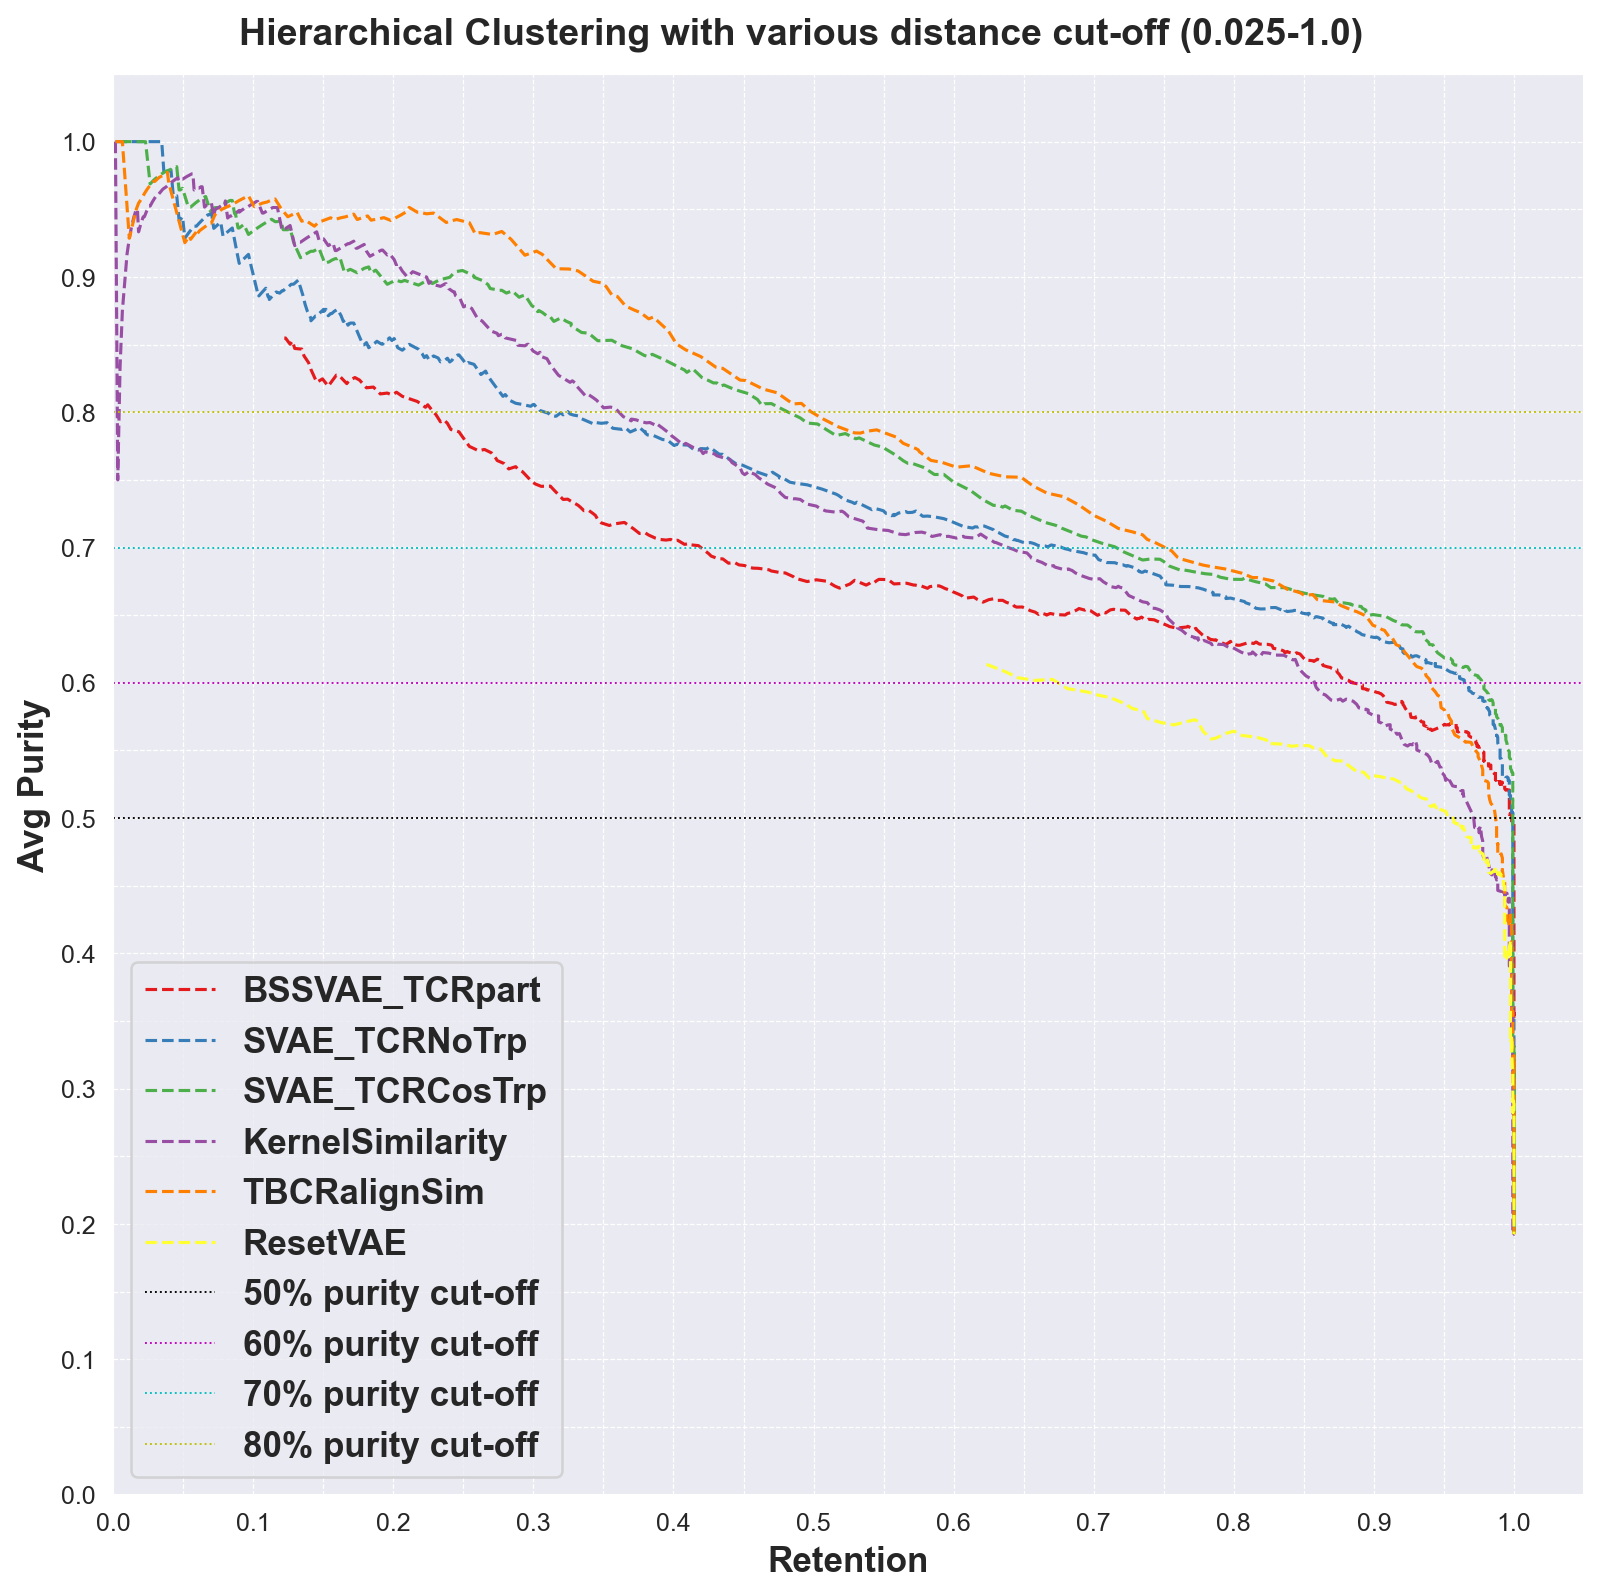

In [750]:
sns.set_palette('Set1', 6)
f,a = plt.subplots(1, 1, figsize=(9,9))
# a = a.ravel()
# a[0].set_xlim([0,1])
# a[0].set_ylim([-1,1])
# # This plot should show that low distance = high purity, and more pure = better for lower distances
# # If low distance and low purity then the model didn't do too well
# a[0].set_xlabel('Avg Purity')
# a[0].set_ylabel('Silhouette Score')
# a[0].plot(bss_arrays[:, 0], bss_arrays[:, 2], label='BSSVAE_TCRpart', ls='--', lw=1.25) 
# a[0].plot(not_arrays[:, 0], not_arrays[:, 2], label='SVAE_TCRNoTrp', ls='--', lw=1.25) 
# a[0].plot(cos_arrays[:, 0], cos_arrays[:, 2], label='SVAE_TCRCosTrp', ls='--', lw=1.25) 
# a[0].plot(ker_arrays[:, 0], ker_arrays[:, 2], label='KernelSimilarity', ls='--', lw=1.25) 
# a[0].legend()

a.set_xlim([0,1])
a.set_ylim([0,1])
a.set_xlabel('Retention', fontweight='semibold', fontsize=14)
a.set_ylabel('Avg Purity', fontweight='semibold', fontsize=14)
major_ticks = np.arange(0, 1.1, 0.1)
a.set_xticks(major_ticks)

a.set_yticks(major_ticks)

# Set the minor ticks
minor_ticks = np.arange(0, 1.1, 0.05)
a.set_xticks(minor_ticks, minor=True)

a.set_yticks(minor_ticks, minor=True)

plt.grid(which='both', linestyle='--', linewidth=0.5)
a.plot(bss_arrays[:, 1], bss_arrays[:, 0], label='BSSVAE_TCRpart', ls='--', lw=1.25) 
a.plot(not_arrays[:, 1], not_arrays[:, 0], label='SVAE_TCRNoTrp', ls='--', lw=1.25) 
a.plot(cos_arrays[:, 1], cos_arrays[:, 0], label='SVAE_TCRCosTrp', ls='--', lw=1.25) 
a.plot(ker_arrays[:, 1], ker_arrays[:, 0], label='KernelSimilarity', ls='--', lw=1.25) 
a.plot(tbr_arrays[:, 1], tbr_arrays[:, 0], label='TBCRalignSim', ls='--', lw=1.25) 
a.plot(res_arrays[:, 1], res_arrays[:, 0], label='ResetVAE', ls='--', lw=1.25) 

a.axhline(0.5, label='50% purity cut-off', ls=':', lw=.75, c='k')
a.axhline(0.6, label='60% purity cut-off', ls=':', lw=.75, c='m')
a.axhline(0.7, label='70% purity cut-off', ls=':', lw=.75, c='c')
a.axhline(0.8, label='80% purity cut-off', ls=':', lw=.75, c='y')
# a.axhline(0.99, label='99% purity/retention HOW??', ls='-.', lw=.5, c='g')
# a.axvline(0.99, ls='-.', lw=.5, c='g')
a.legend(prop={'weight':'semibold','size':14})
f.suptitle('Hierarchical Clustering with various distance cut-off (0.025-1.0)', fontweight='semibold', fontsize=15)
f.tight_layout()

In [636]:
# what the FUCK

tbcrdist_results.query('0.7<retention<0.7 and mean_purity>0.99')


,threshold,n_cluster,n_singletons,n_cluster_over_70p,mean_purity,min_purity,max_purity,mean_coherence,min_coherence,max_coherence,mean_cluster_size,min_cluster_size,max_cluster_size,silhouette,ch_index,db_index,ARI,retention
109,0.09590,150,12,136,0.992754,0.5,1.0,0.056193,0.033161,0.093977,8.688406,2,138,-0.375570,2.755065,3.800121,0.278493,0.990091
110,0.09655,144,11,131,0.992481,0.5,1.0,0.056271,0.033161,0.093977,9.022556,2,138,-0.365998,2.818629,3.868082,0.282486,0.990917
111,0.09720,143,10,131,0.992481,0.5,1.0,0.056297,0.033161,0.093977,9.030075,2,138,-0.366797,2.813143,3.893518,0.282673,0.991742
112,0.09785,142,10,130,0.992424,0.5,1.0,0.056317,0.033161,0.093977,9.098485,2,138,-0.366825,2.823071,3.904596,0.283111,0.991742
113,0.09850,136,10,124,0.992063,0.5,1.0,0.056995,0.033161,0.093977,9.531746,2,138,-0.364271,2.889969,3.999646,0.288376,0.991742
114,0.09915,135,10,123,0.992000,0.5,1.0,0.057027,0.033161,0.093977,9.608000,2,138,-0.364214,2.905398,4.009441,0.288811,0.991742
115,0.09980,131,10,119,0.991736,0.5,1.0,0.057533,0.033161,0.093977,9.925620,2,138,-0.364896,2.914407,4.064167,0.291184,0.991742
116,0.10045,130,10,118,0.991667,0.5,1.0,0.057526,0.033161,0.093977,10.008333,2,138,-0.361137,2.926330,4.080857,0.291308,0.991742
117,0.10110,126,10,114,0.991379,0.5,1.0,0.057982,0.033161,0.093977,10.353448,2,138,-0.362675,2.962723,4.109620,0.296777,0.991742


In [681]:
def get_stuff(cluster_label:int, 
                                true_labels:list, 
                                pred_labels:list, 
                                dist_array:np.array,
                                label_encoder):
    """
        For a given cluster label (int) returned by clustering.labels_, 
        Return the purity, mixity, coherence, cluster_size, and scale (==cluster_size/total_size)
        scale should be used to get a weighted average metric at the end
    """
    indices = np.where(pred_labels==cluster_label)[0]
    cluster_size = len(indices)
    if cluster_size<=1:
        # return np.nan, np.nan, np.nan, 1, 1/len(true_labels)
        return {'purity':np.nan, 'coherence':np.nan, 'cluster_size':1}

    # Query the subset of the true labels belonging to this cluster using indices 
    # Convert to int label encodings in order to use np.bincount to get purity and mixity
    subset = true_labels[indices]
    encoded_subset = label_encoder.transform(subset)
    counts = {i:k for i,k in enumerate(np.bincount(encoded_subset)) if k>0}
    
    purity = get_purity(counts)
    # mixity = get_mixity(counts)
    # index the distance matrix and return the mean distance within this cluster (i.e. coherence)
    coherence = get_coherence(dist_array[indices][:, indices])
    
    # return purity, mixity, coherence, cluster_size, cluster_size / len(true_labels)
    decoded_counts = dict(zip(label_encoder.inverse_transform(list(counts.keys())), counts.values()))
    majority_label = list(dict(sorted(decoded_counts.items(), key=lambda item: item[1], reverse=True)).keys())[0]

    return {'counts':  decoded_counts, 'majority_label':majority_label, 'indices':indices, 
            'subset':subset, 'purity':purity, 'coherence':coherence, 'cluster_size':cluster_size}

In [751]:
# Run TCRBase for ALL peptides and all crossvalidation folds